# 動画データに対するDLとECOの概要
動画のクラス分類に，Efficient Convolutional Network for Online Video Understanding，ECOというモデルを用いる  

## データをDLで扱う際の注意点
動画を静止画をいずれかの次元にたくさん繋げた長い画像ととらえるだけではダメ  
画像を長い画像としてとらえると，例えばどこからどこまでが「お皿を洗っている」というような情報がわからない

## 動画データをDLで扱う方法
2次元の時は物体の位置がどこにあるかわからない問題を畳み込みで解決していた  
それと同様に，3次元の畳み込みを行い，時間方向の揺らぎを吸収するようにしたい  
  
3次元畳み込みの手法のC3D(COnvolutional 3D)は3次元のフィルタを使用している  
  
Two-Stream ConvNetsでは時間の概念を持つ静止画を別に用意して静止画とペアにしている  
Two-Streamでは時間情報を扱うのにOptical Flowという情報を使用している  
Optical Flowは連続する2枚のフレーム間の物体が移動した軌跡をベクトルで表した画像  
  
C3DはOptical Flowをデータから直接学習していると考えられるが，効率が悪い  
ECOは先にフレーム画像を畳み込んで小さくし，それをC3Dに入力して効率を改善する  

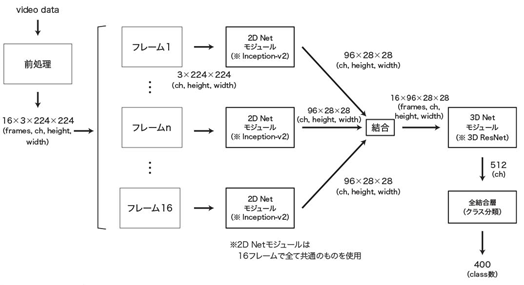

1. 動画をフレームごとの画像に分解し，リサイズと標準化を行う  
1. 全フレームを使用すると多いので等間隔に16フレームほど取り出す  
    - 結果，動画データのミニバッチは(M,16,3,224,224)のテンソルになる  
1. これらのフレーム画像をそれぞれInception-v2からなる2DNetモジュールに入力  
1. 2DNetの各出力を再結合し，ResNetからなる3DNetモジュールに入力
1. Softmaxで400クラスに分類し，分類確率を得る

# 2DNetモジュールの実装
Inception-v2による2DNetモジュールの実装

In [1]:
import torch
from torch import nn

## ECOの2DNetモジュールの概要
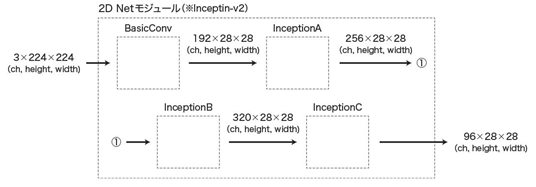

- BasicConv: CNNによる特徴量変換
- InceptionA～C: さらに特徴量変換

## BasicConvの実装
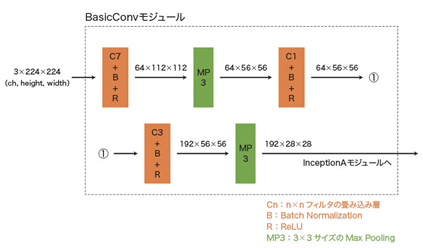

In [2]:
class BasicConv(nn.Module):
    def __init__(self):
        super(BasicConv, self).__init__()
        self.conv1_7x7_s2 = nn.Conv2d(3, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3))
        self.conv1_7x7_s2_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv1_relu_7x7 = nn.ReLU(inplace=True)
        
        self.pool1_3x3_s2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
        
        self.conv2_3x3_reduce = nn.Conv2d(64, 64, kernel_size=(1,1), stride=(1,1))
        self.conv2_3x3_reduce_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_relu_3x3_reduce = nn.ReLU(inplace=True)
        
        self.conv2_3x3 = nn.Conv2d(64, 192, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv2_3x3_bn = nn.BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_relu_3x3 = nn.ReLU(inplace=True)
        
        self.pool2_3x3_s2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    
    def forward(self, x):
        out = self.conv1_7x7_s2(x)
        out = self.conv1_7x7_s2_bn(out)
        out = self.conv1_relu_7x7(out)
        
        out = self.pool1_3x3_s2(out)
        
        out = self.conv2_3x3_reduce(out)
        out = self.conv2_3x3_reduce_bn(out)
        out = self.conv2_relu_3x3_reduce(out)
        
        out = self.conv2_3x3(out)
        out = self.conv2_3x3_bn(out)
        out = self.conv2_relu_3x3(out)
        
        out = self.pool2_3x3_s2(out)

        return out

## InceptionA~Cの実装
InceptionはGoogLeNetで提案された手法で入力が分岐して並列に畳み込みされる  
例えば，5x5のフィルタで左上の2x2,右下の3x3が強かったとする  
これは5x5を使うよりも2x2と3x3を並列で両方使った方がパラメータが少なくて済む  
  
また，pointwise convolutionでチャネルの次元圧縮も行う  
  
ECOで使うのはInception-v2で，上から3番目のフローが5x5から3x3を2回になっている

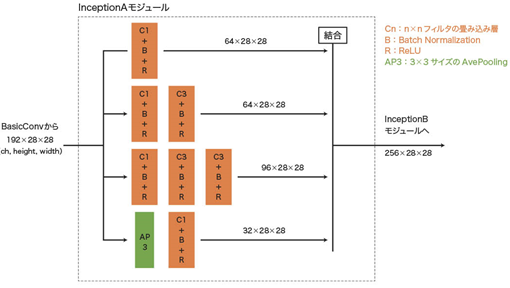

In [3]:
class InceptionA(nn.Module):
    def __init__(self):
        super(InceptionA, self).__init__()
        
        self.inception_3a_1x1 = nn.Conv2d(192, 64, kernel_size=(1,1), stride=(1,1))
        self.inception_3a_1x1_bn = nn.BatchNorm2d(64, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3a_relu_1x1 = nn.ReLU(inplace=True)
        
        self.inception_3a_3x3_reduce = nn.Conv2d(192, 64, kernel_size=(1,1), stride=(1,1))
        self.inception_3a_3x3_reduce_bn = nn.BatchNorm2d(64, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3a_relu_3x3_reduce = nn.ReLU(inplace=True)
        self.inception_3a_3x3 = nn.Conv2d(64, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.inception_3a_3x3_bn = nn.BatchNorm2d(64, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3a_relu_3x3 = nn.ReLU(inplace=True)
        
        self.inception_3a_double_3x3_reduce = nn.Conv2d(192, 64, kernel_size=(1,1), stride=(1,1))
        self.inception_3a_double_3x3_reduce_bn = nn.BatchNorm2d(64, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3a_double_relu_3x3_reduce = nn.ReLU(inplace=True)
        self.inception_3a_double_3x3_1 = nn.Conv2d(64, 96, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.inception_3a_double_3x3_1_bn = nn.BatchNorm2d(96, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3a_double_relu_3x3_1 = nn.ReLU(inplace=True)
        self.inception_3a_double_3x3_2 = nn.Conv2d(96, 96, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.inception_3a_double_3x3_2_bn = nn.BatchNorm2d(96, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3a_double_relu_3x3_2 = nn.ReLU(inplace=True)
        
        self.inception_3a_pool = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)
        self.inception_3a_pool_proj = nn.Conv2d(192, 32, kernel_size=(1,1), stride=(1,1))
        self.inception_3a_pool_proj_bn = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3a_relu_pool_proj = nn.ReLU(inplace=True)
    
    def forward(self, x):
        out1 = self.inception_3a_1x1(x)
        out1 = self.inception_3a_1x1_bn(out1)
        out1 = self.inception_3a_relu_1x1(out1)
        
        out2 = self.inception_3a_3x3_reduce(x)
        out2 = self.inception_3a_3x3_reduce_bn(out2)
        out2 = self.inception_3a_relu_3x3_reduce(out2)
        out2 = self.inception_3a_3x3(out2)
        out2 = self.inception_3a_3x3_bn(out2)
        out2 = self.inception_3a_relu_3x3(out2)
        
        out3 = self.inception_3a_double_3x3_reduce(x)
        out3 = self.inception_3a_double_3x3_reduce_bn(out3)
        out3 = self.inception_3a_double_relu_3x3_reduce(out3)
        out3 = self.inception_3a_double_3x3_1(out3)
        out3 = self.inception_3a_double_3x3_1_bn(out3)
        out3 = self.inception_3a_double_relu_3x3_1(out3)
        out3 = self.inception_3a_double_3x3_2(out3)
        out3 = self.inception_3a_double_3x3_2_bn(out3)
        out3 = self.inception_3a_double_relu_3x3_2(out3)
        
        out4 = self.inception_3a_pool(x)
        out4 = self.inception_3a_pool_proj(out4)
        out4 = self.inception_3a_pool_proj_bn(out4)
        out4 = self.inception_3a_relu_pool_proj(out4)
        
        outputs = [out1, out2, out3, out4]
        return torch.cat(outputs, 1)

InceptionB  
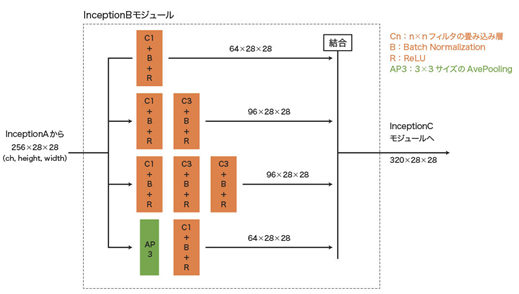

In [4]:
class InceptionB(nn.Module):
    def __init__(self):
        super(InceptionB, self).__init__()
        
        self.inception_3b_1x1 = nn.Conv2d(256, 64, kernel_size=(1,1), stride=(1,1))
        self.inception_3b_1x1_bn = nn.BatchNorm2d(64, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3b_relu_1x1 = nn.ReLU(inplace=True)
        
        self.inception_3b_3x3_reduce = nn.Conv2d(256, 64, kernel_size=(1,1), stride=(1,1))
        self.inception_3b_3x3_reduce_bn = nn.BatchNorm2d(64, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3b_relu_3x3_reduce = nn.ReLU(inplace=True)
        self.inception_3b_3x3 = nn.Conv2d(64, 96, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.inception_3b_3x3_bn = nn.BatchNorm2d(96, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3b_relu_3x3 = nn.ReLU(inplace=True)
        
        self.inception_3b_double_3x3_reduce = nn.Conv2d(256, 64, kernel_size=(1,1), stride=(1,1))
        self.inception_3b_double_3x3_reduce_bn = nn.BatchNorm2d(64, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3b_double_relu_3x3_reduce = nn.ReLU(inplace=True)
        self.inception_3b_double_3x3_1 = nn.Conv2d(64, 96, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.inception_3b_double_3x3_1_bn = nn.BatchNorm2d(96, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3b_double_relu_3x3_1 = nn.ReLU(inplace=True)
        self.inception_3b_double_3x3_2 = nn.Conv2d(96, 96, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.inception_3b_double_3x3_2_bn = nn.BatchNorm2d(96, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3b_double_relu_3x3_2 = nn.ReLU(inplace=True)
        
        self.inception_3b_pool = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)
        self.inception_3b_pool_proj = nn.Conv2d(256, 64, kernel_size=(1,1), stride=(1,1))
        self.inception_3b_pool_proj_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3b_relu_pool_proj = nn.ReLU(inplace=True)
    
    def forward(self, x):
        out1 = self.inception_3b_1x1(x)
        out1 = self.inception_3b_1x1_bn(out1)
        out1 = self.inception_3b_relu_1x1(out1)
        
        out2 = self.inception_3b_3x3_reduce(x)
        out2 = self.inception_3b_3x3_reduce_bn(out2)
        out2 = self.inception_3b_relu_3x3_reduce(out2)
        out2 = self.inception_3b_3x3(out2)
        out2 = self.inception_3b_3x3_bn(out2)
        out2 = self.inception_3b_relu_3x3(out2)
        
        out3 = self.inception_3b_double_3x3_reduce(x)
        out3 = self.inception_3b_double_3x3_reduce_bn(out3)
        out3 = self.inception_3b_double_relu_3x3_reduce(out3)
        out3 = self.inception_3b_double_3x3_1(out3)
        out3 = self.inception_3b_double_3x3_1_bn(out3)
        out3 = self.inception_3b_double_relu_3x3_1(out3)
        out3 = self.inception_3b_double_3x3_2(out3)
        out3 = self.inception_3b_double_3x3_2_bn(out3)
        out3 = self.inception_3b_double_relu_3x3_2(out3)
        
        out4 = self.inception_3b_pool(x)
        out4 = self.inception_3b_pool_proj(out4)
        out4 = self.inception_3b_pool_proj_bn(out4)
        out4 = self.inception_3b_relu_pool_proj(out4)
        
        outputs = [out1, out2, out3, out4]
        return torch.cat(outputs, 1)

InceptionC
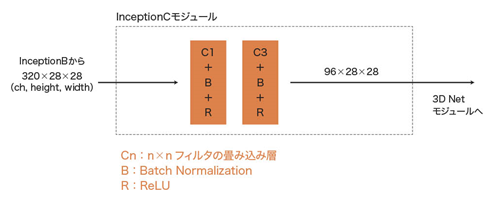

In [5]:
class InceptionC(nn.Module):
    def __init__(self):
        super(InceptionC, self).__init__()
        
        self.inception_3c_double_3x3_reduce = nn.Conv2d(320, 64, kernel_size=(1,1), stride=(1,1))
        self.inception_3c_double_3x3_reduce_bn = nn.BatchNorm2d(64, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3c_double_relu_3x3_reduce = nn.ReLU(inplace=True)
        self.inception_3c_double_3x3_1 = nn.Conv2d(64, 96, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.inception_3c_double_3x3_1_bn = nn.BatchNorm2d(96, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3c_double_relu_3x3_1 = nn.ReLU(inplace=True)
            
    def forward(self, x):
        out = self.inception_3c_double_3x3_reduce(x)
        out = self.inception_3c_double_3x3_reduce_bn(out)
        out = self.inception_3c_double_relu_3x3_reduce(out)
        out = self.inception_3c_double_3x3_1(out)
        out = self.inception_3c_double_3x3_1_bn(out)
        out = self.inception_3c_double_relu_3x3_1(out)
        return out

以上をまとめてECOの2DNetモジュールクラスを作成

In [6]:
class ECO_2D(nn.Module):
    def __init__(self):
        super(ECO_2D, self).__init__()
        
        self.basic_conv = BasicConv()
        self.inceptionA = InceptionA()
        self.inceptionB = InceptionB()
        self.inceptionC = InceptionC()
        
    def forward(self, x):
        out = self.basic_conv(x)
        out = self.inceptionA(out)
        out = self.inceptionB(out)
        out = self.inceptionC(out)
        return out

TensorBoardでテンソルサイズの確認

In [7]:
net = ECO_2D()
net.train()

ECO_2D(
  (basic_conv): BasicConv(
    (conv1_7x7_s2): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (conv1_7x7_s2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1_relu_7x7): ReLU(inplace)
    (pool1_3x3_s2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2_3x3_reduce): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv2_3x3_reduce_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2_relu_3x3_reduce): ReLU(inplace)
    (conv2_3x3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_3x3_bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2_relu_3x3): ReLU(inplace)
    (pool2_3x3_s2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (inceptionA): InceptionA(
    (inception_3a_1x1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
 

In [8]:
# from tensorboardX import SummaryWriter
# writer = SummaryWriter("./tbX/")
# batch_size = 1
# dummy_img = torch.rand(batch_size, 3, 224, 224)
# writer.add_graph(net, (dummy_img,))
# writer.close()

`$ tensorboard --logdir="./tbX"`  
6006ポートへアクセス

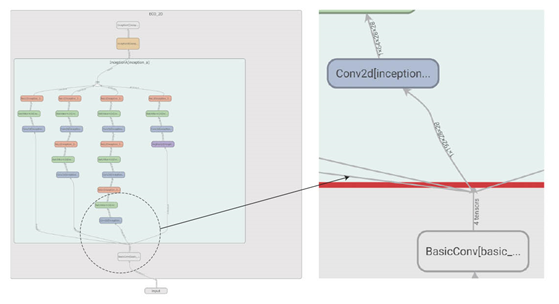  
こういう感じに可視化できる

# 3DNetモジュール(3DCNN)の実装

## ECOの3DNetモジュールの概要
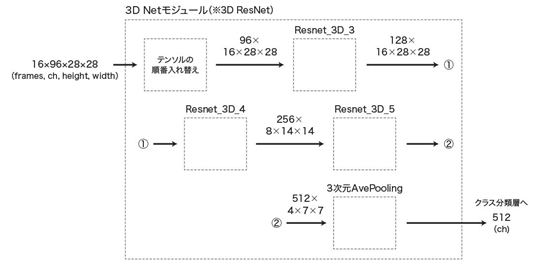
2DNetの(96,28,28)のフレームごとの特徴量を16個まとめた(16,96,28,28)を受け取る  
  
最後の層ではAvgPoolingで(512)を作る．  
これまでプーリングは物体の位置が多少移動しても同じ特徴量を得る目的で使用していた．  
しかしこの最後の層では，パラメータを減らして過学習を防ぐために使用する  
このような全結合層の代わりに使用するAvgPoolingをGlobal Average Poolingと呼ぶ

## Resnet_3D_3の実装
テンソルの順番入れ替えはここのforwardでやる  
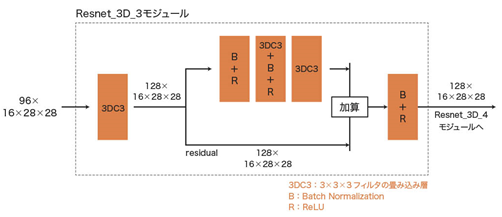

In [9]:
class Resnet_3D_3(nn.Module):
    def __init__(self):
        super(Resnet_3D_3, self).__init__()
        
        self.res3a_2 = nn.Conv3d(96, 128, kernel_size=(3,3,3), stride=(1,1,1), padding=(1,1,1))
        
        self.res3a_bn = nn.BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res3a_relu = nn.ReLU(inplace=True)
        
        self.res3b_1 = nn.Conv3d(128, 128, kernel_size=(3,3,3), stride=(1,1,1), padding=(1,1,1))
        self.res3b_1_bn = nn.BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res3b_1_relu = nn.ReLU(inplace=True)
        self.res3b_2 = nn.Conv3d(128, 128, kernel_size=(3,3,3), stride=(1,1,1), padding=(1,1,1))
        
        self.res3b_bn = nn.BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res3b_relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        residual = self.res3a_2(x)
        out = self.res3a_bn(residual)
        out = self.res3a_relu(out)
        
        out = self.res3b_1(out)
        out = self.res3b_1_bn(out)
        out = self.res3b_relu(out)
        out = self.res3b_2(out)
        
        out += residual
        out = self.res3b_bn(out)
        out = self.res3b_relu(out)
        
        return out

## Resnet_3D_4の実装
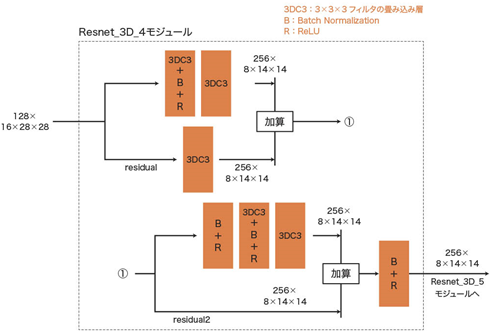

In [10]:
class Resnet_3D_4(nn.Module):
    def __init__(self):
        super(Resnet_3D_4, self).__init__()
        
        self.res4a_1 = nn.Conv3d(128, 256, kernel_size=(3,3,3), stride=(2,2,2), padding=(1,1,1))
        self.res4a_1_bn = nn.BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res4a_1_relu = nn.ReLU(inplace=True)
        self.res4a_2 = nn.Conv3d(256, 256, kernel_size=(3,3,3), stride=(1,1,1), padding=(1,1,1))
        
        self.res4a_down = nn.Conv3d(128, 256, kernel_size=(3,3,3), stride=(2,2,2), padding=(1,1,1))
        
        self.res4a_bn = nn.BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res4a_relu = nn.ReLU(inplace=True)
        
        self.res4b_1 = nn.Conv3d(256, 256, kernel_size=(3,3,3), stride=(1,1,1), padding=(1,1,1))
        self.res4b_1_bn = nn.BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res4b_1_relu = nn.ReLU(inplace=True)
        self.res4b_2 = nn.Conv3d(256, 256, kernel_size=(3,3,3), stride=(1,1,1), padding=(1,1,1))
        
        self.res4b_bn = nn.BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res4b_relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        residual = self.res4a_down(x)
        
        out = self.res4a_1(x)
        out = self.res4a_1_bn(out)
        out = self.res4a_1_relu(out)
        
        out = self.res4a_2(out)
        
        out += residual
        
        residual2 = out
        
        out = self.res4a_bn(out)
        out = self.res4a_relu(out)
        
        out = self.res4b_1(out)
        
        out = self.res4b_1_bn(out)
        out = self.res4b_1_relu(out)
        
        out = self.res4b_2(out)
        
        out += residual2
        
        out = self.res4b_bn(out)
        out = self.res4b_relu(out)
        
        return out

## Resnet_3D_5の実装
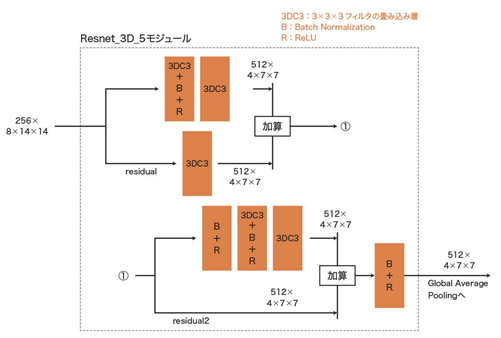

In [11]:
class Resnet_3D_5(nn.Module):
    def __init__(self):
        super(Resnet_3D_5, self).__init__()
        
        self.res5a_1 = nn.Conv3d(256, 512, kernel_size=(3,3,3), stride=(2,2,2), padding=(1,1,1))
        self.res5a_1_bn = nn.BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res5a_1_relu = nn.ReLU(inplace=True)
        self.res5a_2 = nn.Conv3d(512, 512, kernel_size=(3,3,3), stride=(1,1,1), padding=(1,1,1))
        
        self.res5a_down = nn.Conv3d(256, 512, kernel_size=(3,3,3), stride=(2,2,2), padding=(1,1,1))
        
        self.res5a_bn = nn.BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res5a_relu = nn.ReLU(inplace=True)
        
        self.res5b_1 = nn.Conv3d(512, 512, kernel_size=(3,3,3), stride=(1,1,1), padding=(1,1,1))
        self.res5b_1_bn = nn.BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res5b_1_relu = nn.ReLU(inplace=True)
        self.res5b_2 = nn.Conv3d(512, 512, kernel_size=(3,3,3), stride=(1,1,1), padding=(1,1,1))
        
        self.res5b_bn = nn.BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res5b_relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        residual = self.res5a_down(x)
        
        out = self.res5a_1(x)
        out = self.res5a_1_bn(out)
        out = self.res5a_1_relu(out)
        
        out = self.res5a_2(out)
        
        out += residual
        
        residual2 = out
    
        out = self.res5a_bn(out)
        out = self.res5a_relu(out)
        
        out = self.res5b_1(out)
        
        out = self.res5b_1_bn(out)
        out = self.res5b_1_relu(out)
        
        out = self.res5b_2(out)
        
        out += residual2
        
        out = self.res5b_bn(out)
        out = self.res5b_relu(out)
        
        return out

以上をまとめてECO 3D Netモジュールクラスを実装

In [12]:
class ECO_3D(nn.Module):
    def __init__(self):
        super(ECO_3D, self).__init__()
        
        # 3D Resnetモジュール
        self.res_3d_3 = Resnet_3D_3()
        self.res_3d_4 = Resnet_3D_4()
        self.res_3d_5 = Resnet_3D_5()
        
        # Global Average Poolingによるクラス分類確率化
        self.global_pool = nn.AvgPool3d(kernel_size=(4,7,7), stride=1, padding=0)
    
    def forward(self, x):
        """
        Input: (M, frames, 96, 28, 28)
        """
        
        out = torch.transpose(x, 1, 2)
        out = self.res_3d_3(out)
        out = self.res_3d_4(out)
        out = self.res_3d_5(out)
        out = self.global_pool(out)
        
        # (M, 512, 1, 1, 1) -> (M, 512)
        out = out.view(out.size()[0], out.size()[1])
        
        return out

可視化と動作確認

In [13]:
net = ECO_3D()
net.train()

ECO_3D(
  (res_3d_3): Resnet_3D_3(
    (res3a_2): Conv3d(96, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (res3a_bn): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (res3a_relu): ReLU(inplace)
    (res3b_1): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (res3b_1_bn): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (res3b_1_relu): ReLU(inplace)
    (res3b_2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (res3b_bn): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (res3b_relu): ReLU(inplace)
  )
  (res_3d_4): Resnet_3D_4(
    (res4a_1): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (res4a_1_bn): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (res4a_1_relu): ReLU(inplace)
    (res4a_2): Conv3d(256, 256, kernel_size

In [16]:
# from tensorboardX import SummaryWriter
# writer = SummaryWriter("./tbX/")
# batch_size = 1
# dummy_img = torch.rand(batch_size, 16, 96, 28, 28)
# writer.add_graph(net, (dummy_img,))
# writer.close()

ここまでは長かったので，このnotebookを.pyファイルへ変換  
``` bash
jupyter nbconvert --to script 9-2_eco.ipynb
```
eco.pyに名前を変更